In [1]:
  ####
import os
import pickle5 

####

import pandas as pd
import numpy as np
import scipy as sp
import geopandas as gpd
import pysal
from pyproj import Proj, transform
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
import seaborn as sns
from scipy import stats
import powerlaw
import networkx as nx

import matplotlib as mpl
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

/Users/ioana.jelea/opt/anaconda3/envs/lsoa_env/lib/python3.8/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(


In [8]:
def mm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple((i/10)/inch for i in tupl[0])
    else:
        return tuple((i/10)/inch for i in tupl)
    
def load_obj(name ):
    with open('resources/' + name + '.pkl', 'rb') as f:
        return pickle5.load(f)


In [3]:
pclookup = pd.read_csv(r'/Users/ioana.jelea/Documents/Densification and Transport Networks Project/Company House Data Process/PCD_OA_LSOA_MSOA_LAD_FEB20_UK_LU/PCD_OA_LSOA_MSOA_LAD_FEB20_UK_LU.csv', encoding = "ISO-8859-1", low_memory=False)
pclookup = pclookup[['lsoa11cd','msoa11cd']].copy().drop_duplicates()
pclookup.head()

,lsoa11cd,msoa11cd
0,S01006514,S02001237
3,S01006853,S02001296
4,S01006511,S02001236
5,S01006506,S02001236
38,S01006513,S02001237


In [4]:
def convert_to_msoa(data): 
    
    pclookup = pd.read_csv("resources/PCD_OA_LSOA_MSOA_LAD_FEB20_UK_LU.csv", encoding = "ISO-8859-1", low_memory=False)
    pclookup = pclookup[['lsoa11cd','msoa11cd']].copy().drop_duplicates()

    comp_data = pd.read_csv("resources/newdata_companyhouse.csv")
    

    #data_df = pd.DataFrame(data) - already DFs

    data['lsoa11cd'] = comp_data['lsoa11cd'] 
    data_row = pclookup.merge(data, left_on='lsoa11cd', right_on='lsoa11cd', how='right')
    data_row = data_row.groupby('msoa11cd', as_index=False).sum()
    data_trans = data_row.drop('msoa11cd', axis=1).T

    data_trans['lsoa11cd'] = comp_data['lsoa11cd']
    data_col = pclookup.merge(data_trans, left_on='lsoa11cd', right_on='lsoa11cd', how='right')
    data_col = data_col.groupby('msoa11cd', as_index=False).sum()
    data_msoa = data_col.drop('msoa11cd',axis=1).T

#     data_msoa = data_msoa.to_numpy()
#     data_msoa[np.where(np.isinf(data_msoa))[0], np.where(np.isinf(data_msoa))[1]] = 0
#     data_msoa = pd.DataFrame(data_msoa)


    return data_msoa

# Constructing the sheff polygon data conv to msoa

In [9]:
#loading data
scr_data = load_obj('newdata_lsoa_data')
scr = scr_data['sheff_lsoa_shape']

shef = scr_data['sheff_lsoa_shape']
shef = shef.merge(pclookup, on='lsoa11cd', how='left')
shef_m = shef.dissolve(by='msoa11cd', aggfunc='first', as_index=0) #.centroid

## process this as a network as well?
# mc_theta = load_obj(r'/Users/ioana.jelea/Desktop/population_interaction_model_BACKUP/resources/normal_layout_1000run_bus_given_theta')
# scr_d = mc_theta['edge_freqs'][0].mean(axis=0)

# Loading in the mapping data

In [10]:
paths = load_obj('newdata_ave_paths')
paths = pd.DataFrame(paths)
paths_msoa = convert_to_msoa(paths)

paths_msoa = paths_msoa.to_numpy()
paths_msoa[np.diag_indices_from(paths_msoa)] = 0 
paths_msoa = pd.DataFrame(paths_msoa)

paths_msoa.index = shef_m.msoa11cd.values
paths_msoa.columns = shef_m.msoa11cd.values

# gpath=nx.from_numpy_matrix(np.matrix(paths_msoa.values)) - don't need it anymore, it works now
gpath = nx.from_pandas_adjacency(paths_msoa)
nx.set_node_attributes(gpath, dict(zip(shef_m.msoa11cd.values, list(zip(shef_m.centroid.x.values, shef_m.centroid.y.values)))), "pos")


### Note: the 12 tests below represent the scenarios from the report, with the order matching the number from the table 

### The input files are read locally

In [11]:
# tests done at LSOA level

test1 = load_obj('normal_layout_1000run_bus_given_theta_test1')
test1 = pd.DataFrame(data=test1['edge_widths'][0])
test1.index = scr.lsoa11cd.values
test1.columns = scr.lsoa11cd.values
gtt1 = nx.from_pandas_adjacency(test1)
nx.set_node_attributes(gtt1, dict(zip(scr.lsoa11cd.values, list(zip(scr.centroid.x.values, scr.centroid.y.values)))), "pos")

test2 = load_obj('normal_layout_1000run_bus_given_theta_test2')
test2 = pd.DataFrame(data=test2['edge_widths'][0])
test2.index = scr.lsoa11cd.values
test2.columns = scr.lsoa11cd.values
gtt2 = nx.from_pandas_adjacency(test2)
nx.set_node_attributes(gtt2, dict(zip(scr.lsoa11cd.values, list(zip(scr.centroid.x.values, scr.centroid.y.values)))), "pos")

test3 = load_obj('normal_layout_1000run_bus_given_theta_test3')
test3 = pd.DataFrame(data=test3['edge_widths'][0])
test3.index = scr.lsoa11cd.values
test3.columns = scr.lsoa11cd.values
gtt3 = nx.from_pandas_adjacency(test3)
nx.set_node_attributes(gtt3, dict(zip(scr.lsoa11cd.values, list(zip(scr.centroid.x.values, scr.centroid.y.values)))), "pos")

test4 = load_obj('normal_layout_1000run_bus_given_theta_test4')
test4 = pd.DataFrame(data=test4['edge_widths'][0])
test4.index = scr.lsoa11cd.values
test4.columns = scr.lsoa11cd.values
gtt4 = nx.from_pandas_adjacency(test4)
nx.set_node_attributes(gtt4, dict(zip(scr.lsoa11cd.values, list(zip(scr.centroid.x.values, scr.centroid.y.values)))), "pos")


In [316]:
# tests done at LSOA level

test5 = load_obj('normal_layout_1000run_bus_given_theta_test5')
test5 = pd.DataFrame(data=test5['edge_widths'][0])
test5.index = scr.lsoa11cd.values
test5.columns = scr.lsoa11cd.values
gtt5 = nx.from_pandas_adjacency(test5)
nx.set_node_attributes(gtt5, dict(zip(scr.lsoa11cd.values, list(zip(scr.centroid.x.values, scr.centroid.y.values)))), "pos")

test6 = load_obj('normal_layout_1000run_bus_given_theta_test6')
test6 = pd.DataFrame(data=test6['edge_widths'][0])
test6.index = scr.lsoa11cd.values
test6.columns = scr.lsoa11cd.values
gtt6 = nx.from_pandas_adjacency(test6)
nx.set_node_attributes(gtt6, dict(zip(scr.lsoa11cd.values, list(zip(scr.centroid.x.values, scr.centroid.y.values)))), "pos")

test7 = load_obj('normal_layout_1000run_bus_given_theta_test7')
test7 = pd.DataFrame(data=test7['edge_widths'][0])
test7.index = scr.lsoa11cd.values
test7.columns = scr.lsoa11cd.values
gtt7 = nx.from_pandas_adjacency(test7)
nx.set_node_attributes(gtt7, dict(zip(scr.lsoa11cd.values, list(zip(scr.centroid.x.values, scr.centroid.y.values)))), "pos")

test8 = load_obj('normal_layout_1000run_bus_given_theta_test8')
test8 = pd.DataFrame(data=test8['edge_widths'][0])
test8.index = scr.lsoa11cd.values
test8.columns = scr.lsoa11cd.values
gtt8 = nx.from_pandas_adjacency(test8)
nx.set_node_attributes(gtt8, dict(zip(scr.lsoa11cd.values, list(zip(scr.centroid.x.values, scr.centroid.y.values)))), "pos")

In [315]:
# tests done at LSOA level

test9 = load_obj('normal_layout_1000run_bus_given_theta_test9')
test9 = pd.DataFrame(data=test9['edge_widths'][0])
test9.index = scr.lsoa11cd.values
test9.columns = scr.lsoa11cd.values
gtt9 = nx.from_pandas_adjacency(test9)
nx.set_node_attributes(gtt9, dict(zip(scr.lsoa11cd.values, list(zip(scr.centroid.x.values, scr.centroid.y.values)))), "pos")

test10 = load_obj('normal_layout_1000run_bus_given_theta_test10')
test10 = pd.DataFrame(data=test10['edge_widths'][0])
test10.index = scr.lsoa11cd.values
test10.columns = scr.lsoa11cd.values
gtt10 = nx.from_pandas_adjacency(test10)
nx.set_node_attributes(gtt10, dict(zip(scr.lsoa11cd.values, list(zip(scr.centroid.x.values, scr.centroid.y.values)))), "pos")

test11 = load_obj('normal_layout_1000run_bus_given_theta_test11')
test11 = pd.DataFrame(data=test11['edge_widths'][0])
test11.index = scr.lsoa11cd.values
test11.columns = scr.lsoa11cd.values
gtt11 = nx.from_pandas_adjacency(test11)
nx.set_node_attributes(gtt11, dict(zip(scr.lsoa11cd.values, list(zip(scr.centroid.x.values, scr.centroid.y.values)))), "pos")

test12 = load_obj('normal_layout_1000run_bus_given_theta_test12')
test12 = pd.DataFrame(data=test12['edge_widths'][0])
test12.index = scr.lsoa11cd.values
test12.columns = scr.lsoa11cd.values
gtt12 = nx.from_pandas_adjacency(test12)
nx.set_node_attributes(gtt12, dict(zip(scr.lsoa11cd.values, list(zip(scr.centroid.x.values, scr.centroid.y.values)))), "pos")

In [305]:
def figure_comp(m1,m2,m3):
    fig = plt.figure(figsize=mm2inch(800, 800/4.5))
    gs = gridspec.GridSpec(1, 3, height_ratios=[1], width_ratios=[1, 1, 1], wspace=0.1, hspace=0.08)
    ax11 = fig.add_subplot(gs[0])
    ax12 = fig.add_subplot(gs[1])
    ax13 = fig.add_subplot(gs[2]) 

    gfig = m1[1].copy()
    threshold = np.percentile(m1[0].values.ravel(), 1)
    gfig.remove_edges_from([(n1, n2) for n1, n2, w in gfig.edges(data="weight") if w > threshold])
    edges, weights = zip(*nx.get_edge_attributes(gfig,'weight').items())
    wmax = max(list(weights))

    scr.plot(color='gray', ax=ax11)
    nx.draw_networkx_edges(gfig, pos=nx.get_node_attributes(gfig, "pos"),
                           edge_color=[1-(i/wmax) for i in weights],
                           alpha=[1-(i/wmax) for i in weights],
                           ax=ax11)
    ax11.set_xticks([])
    ax11.set_yticks([])


    gfig = m2[1].copy()
    threshold = np.percentile(m2[0].values.ravel(), 1) #[test2.values.ravel()<1], 1)
    gfig.remove_edges_from([(n1, n2) for n1, n2 in gfig.edges() if n1 == n2])
    gfig.remove_edges_from([(n1, n2) for n1, n2, w in gfig.edges(data="weight") if w > threshold])
    edges, weights = zip(*nx.get_edge_attributes(gfig,'weight').items())
    wmax = max(list(weights))

    scr.plot(color='gray', ax=ax12)
    nx.draw_networkx_edges(gfig, pos=nx.get_node_attributes(gfig, "pos"),
                           edge_color=[1-(i/wmax) for i in weights],
                           alpha=[1-(i/wmax) for i in weights],
                           ax=ax12)
    ax12.set_xticks([])
    ax12.set_yticks([])

    #test 9 network
    gfig = m3[1].copy()
    threshold = np.percentile(m3[0].values.ravel(),1) #[commute_matrix.values.ravel()<1], 1)
    gfig.remove_edges_from([(n1, n2) for n1, n2 in gfig.edges() if n1 == n2])
    gfig.remove_edges_from([(n1, n2) for n1, n2, w in gfig.edges(data="weight") if w > threshold])
    edges, weights = zip(*nx.get_edge_attributes(gfig,'weight').items())
    wmax = max(list(weights))

    scr.plot(color='gray', ax=ax13)
    nx.draw_networkx_edges(gfig, pos=nx.get_node_attributes(gfig, "pos"),
                           edge_color=[1-(i/wmax) for i in weights],
                           alpha=[1-(i/wmax) for i in weights],
                           ax=ax13)
    ax13.set_xticks([])
    ax13.set_yticks([])

In [309]:
# theta = min attractivity
m1 = [test1, gtt1]
m2 = [test2, gtt2]
m3 = [test3, gtt3]
m4 = [test4, gtt4]

# theta = 0.21 (from car to commuter)
m5 = [test5, gtt5]
m6 = [test6, gtt6]
m7 = [test7, gtt7]
m8 = [test8, gtt8]

# theta = 1.96 (from bus to commuter)
m9 = [test9, gtt9]
m10 = [test10, gtt10]
m11 = [test11, gtt11]
m12 = [test12, gtt12]

# Existig bus network, current population - different thetas

Sort out the threshold values?

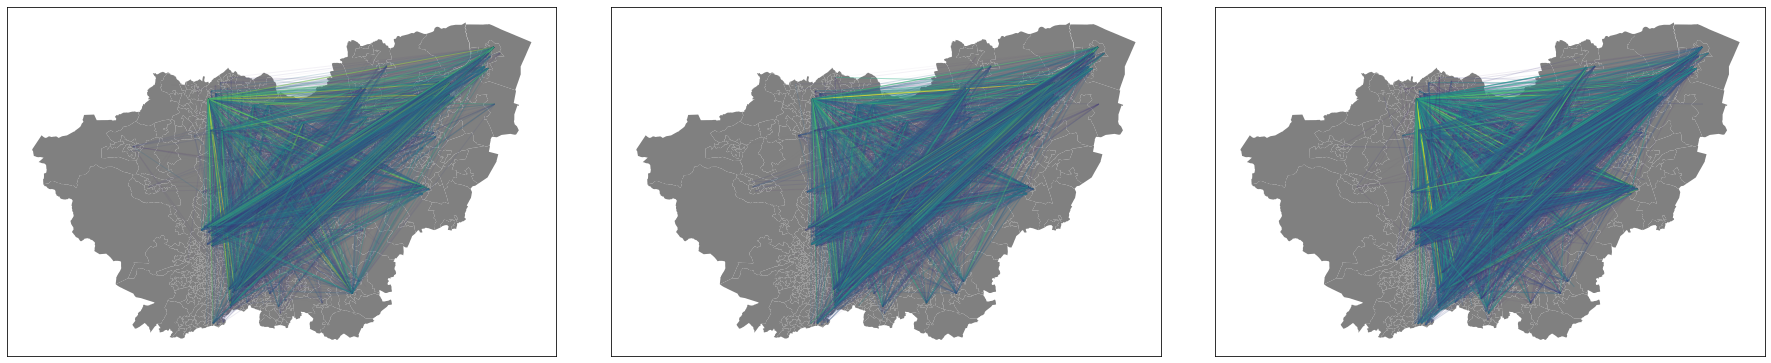

In [310]:
figure_comp(m1, m5, m9)

# Existig bus network, new population - different thetas 

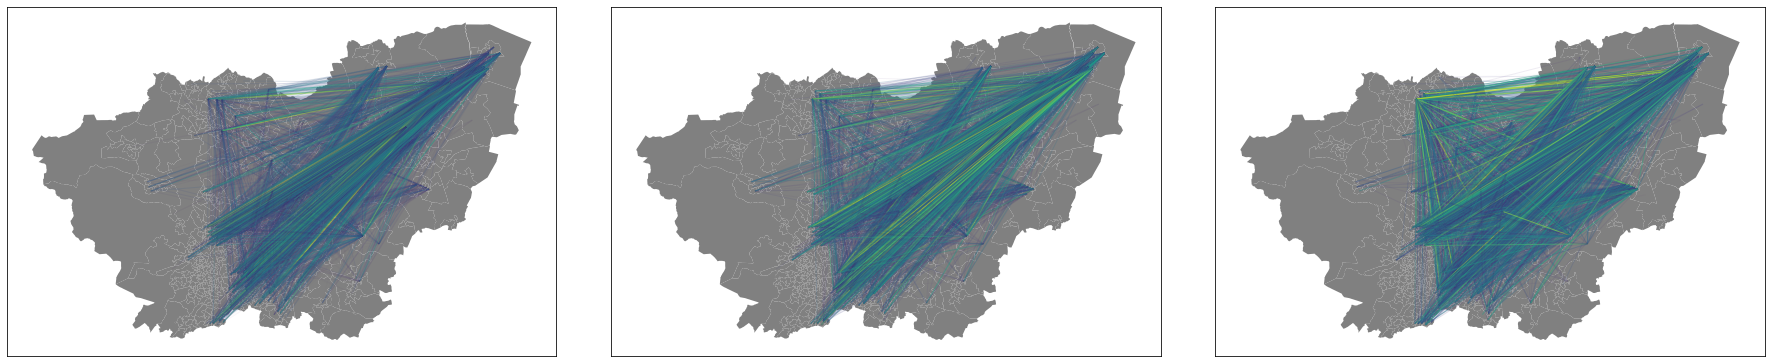

In [303]:
figure_comp(m2, m6, m10)

In [277]:
np.percentile(test.values.ravel(), 1)

159684.30816

### Test

[]

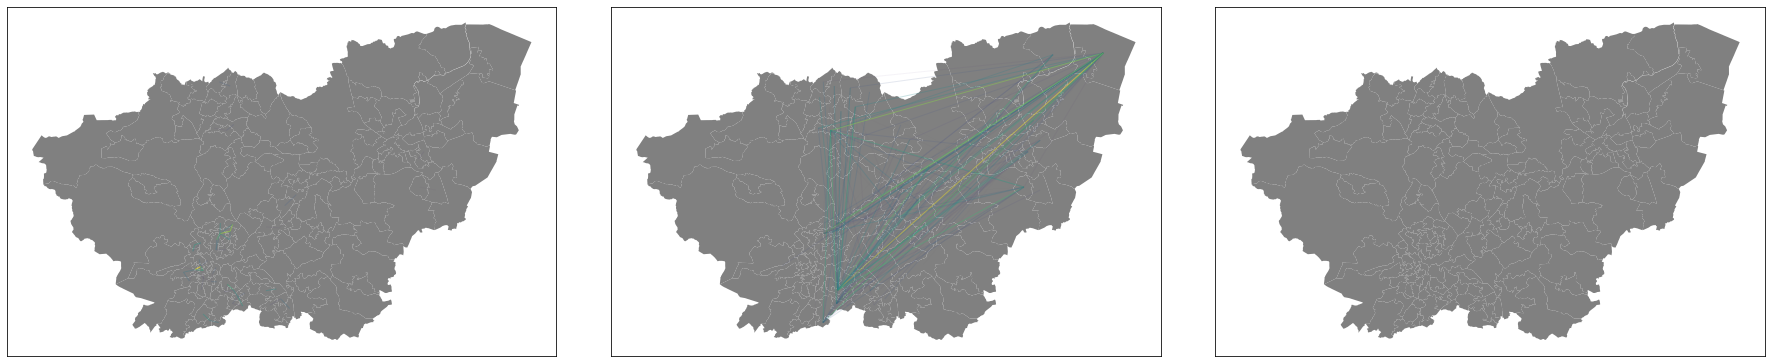

In [263]:
fig = plt.figure(figsize=mm2inch(800, 800/4.5))
gs = gridspec.GridSpec(1, 3, height_ratios=[1], width_ratios=[1, 1, 1], wspace=0.1, hspace=0.08)
ax11 = fig.add_subplot(gs[0])
ax12 = fig.add_subplot(gs[1])
ax13 = fig.add_subplot(gs[2])

#road distances
gfig = gpath.copy()
# threshold = np.percentile(paths_msoa.values.ravel(), 1)
gfig.remove_edges_from([(n1, n2) for n1, n2, w in gfig.edges(data="weight") if w > threshold])
edges, weights = zip(*nx.get_edge_attributes(gfig,'weight').items())
wmax = max(list(weights))

shef_m.plot(color='gray', ax=ax11)
nx.draw_networkx_edges(gfig, pos=nx.get_node_attributes(gfig, "pos"),
                       edge_color=[1-(i/wmax) for i in weights],
                       alpha=[1-(i/wmax) for i in weights],
                       ax=ax11)
ax11.set_xticks([])
ax11.set_yticks([])

#car network
gfig = gmt.copy()
threshold = np.percentile(theta_widths.values.ravel(), 1) #[theta_widths.values.ravel()<1], 1)
gfig.remove_edges_from([(n1, n2) for n1, n2 in gfig.edges() if n1 == n2])
gfig.remove_edges_from([(n1, n2) for n1, n2, w in gfig.edges(data="weight") if w > threshold])
edges, weights = zip(*nx.get_edge_attributes(gfig,'weight').items())
wmax = max(list(weights))

shef_m.plot(color='gray', ax=ax12)
nx.draw_networkx_edges(gfig, pos=nx.get_node_attributes(gfig, "pos"),
                       edge_color=[1-(i/wmax) for i in weights],
                       alpha=[1-(i/wmax) for i in weights],
                       ax=ax12)
ax12.set_xticks([])
ax12.set_yticks([])

#car network
gfig = gcomm.copy()
threshold = 1#np.percentile(commute_matrix.values.ravel()[commute_matrix.values.ravel()<1], 1)
gfig.remove_edges_from([(n1, n2) for n1, n2 in gfig.edges() if n1 == n2])
gfig.remove_edges_from([(n1, n2) for n1, n2, w in gfig.edges(data="weight") if w > threshold])
edges, weights = zip(*nx.get_edge_attributes(gfig,'weight').items())
wmax = max(list(weights))

shef_m.plot(color='gray', ax=ax13)
nx.draw_networkx_edges(gfig, pos=nx.get_node_attributes(gfig, "pos"),
                       edge_color=[1-(i/wmax) for i in weights],
                       alpha=[1-(i/wmax) for i in weights],
                       ax=ax13)
ax13.set_xticks([])
ax13.set_yticks([])


#m bus modifiers - currently unchanged 
# gfig = gm.copy()
# threshold = np.percentile(mbus_msoa.values.ravel(), 99)
# gfig.remove_edges_from([(n1, n2) for n1, n2 in gfig.edges() if n1 == n2])
# gfig.remove_edges_from([(n1, n2) for n1, n2, w in gfig.edges(data="weight") if w < threshold])
# edges, weights = zip(*nx.get_edge_attributes(gfig,'weight').items())
# wmax = max(list(weights))

# shef_m.plot(color='gray', ax=ax13)
# nx.draw_networkx_edges(gfig, pos=nx.get_node_attributes(gfig, "pos"),
#                        edge_color=[1-(i/wmax) for i in weights],
#                        alpha=[1-(i/wmax) for i in weights],
#                        ax=ax13)
# ax13.set_xticks([])
# ax13.set_yticks([])



In [245]:
np.percentile(theta_widths.values.ravel(), 1)#[theta_widths.values.ravel()<1], 1)

3884445.49705

In [256]:
np.percentile(commute_matrix.values.ravel(), 1) #[commute_matrix.values.ravel()<1], 1)

0.0

In [213]:
gfig = gm.copy()
threshold = 5#np.percentile(mbus_msoa.values.ravel()[mbus_msoa.values.ravel()<1], 50)
[(n1, n2, w) for n1, n2, w in gfig.edges(data="weight") if w < threshold]
# sns.displot([w for n1, n2, w in gfig.edges(data="weight")])
np.percentile(mbus_msoa.values.ravel(), 99)

42.0

# Point plots

In [322]:
mc_baseline = load_obj('normal_layout_1000run_bus_given_theta_test5')

mc_test1 = load_obj('normal_layout_1000run_bus_given_theta_test1')
mc_test2 = load_obj('normal_layout_1000run_bus_given_theta_test2')
mc_test3 = load_obj('normal_layout_1000run_bus_given_theta_test3')
mc_test4 = load_obj('normal_layout_1000run_bus_given_theta_test4')

mc_test5 = mc_baseline
mc_test6 = load_obj('normal_layout_1000run_bus_given_theta_test6')
mc_test7 = load_obj('normal_layout_1000run_bus_given_theta_test7')
mc_test8 = load_obj('normal_layout_1000run_bus_given_theta_test8')

mc_test9 = load_obj('normal_layout_1000run_bus_given_theta_test9')
mc_test10 = load_obj('normal_layout_1000run_bus_given_theta_test10')
mc_test11 = load_obj('normal_layout_1000run_bus_given_theta_test11')
mc_test12 = load_obj('normal_layout_1000run_bus_given_theta_test12')

Text(0.0, 1.0, '$\\bf{A}$')

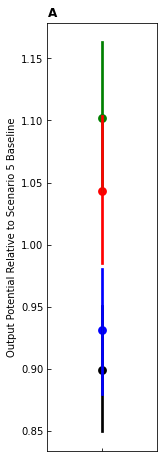

In [324]:
fig = plt.figure(figsize=mm2inch(50, 200))
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], wspace=0.1, hspace=0.08)
ax10 = fig.add_subplot(gs[0])

sns.pointplot(y=(mc_test1['UrbanYs'][0]/np.mean(mc_baseline['UrbanYs'][0])), color='k', ax=ax10, ci=95)
sns.pointplot(y=(mc_test2['UrbanYs'][0]/np.mean(mc_baseline['UrbanYs'][0])), color='g', ax=ax10, ci=95)
sns.pointplot(y=(mc_test3['UrbanYs'][0]/np.mean(mc_baseline['UrbanYs'][0])), color='b', ax=ax10, ci=95)
sns.pointplot(y=(mc_test4['UrbanYs'][0]/np.mean(mc_baseline['UrbanYs'][0])), color='r', ax=ax10, ci=95)

# ax12.set_ylabel('Top 10% Interaction Increase')
ax10.set_ylabel('Output Potential Relative to Scenario 5 Baseline')
# ax13.set_ylabel('')
# ax11.set_xlabel('Sheffield Baseline')
# ax12.set_xlabel('Scenario 1')
# ax13.set_xlabel('Scenario 3')

# ax12.annotate(r'Penalty$\propto$Distance$^{-1}$', (412000,378000))
# ax12.annotate(r'Penalty$\propto$Distance$^{-1.5}$', (415000,380000))
# ax13.annotate(r'Penalty$\propto$Distance$^{-1}$', (412000,378000))

ax10.set_title(r'$\bf{A}$', loc='left', y=1.0)
# ax11.set_title(r'$\bf{B}$', loc='left', y=1.0)
# ax12.set_title(r'$\bf{C}$', loc='left', y=1.0)
# ax13.set_title(r'$\bf{D}$', loc='left', y=1.0)